In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

# 1. Download data

In [2]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

  0%|          | 0/135107811 [00:00<?, ?it/s]

['test', 'train']
['cat', 'horse', 'frog', 'ship', 'deer', 'dog', 'bird', 'automobile', 'truck', 'airplane']


# 2. Data trasform and augmentation

In [3]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [4]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [5]:
batch_size = 256
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


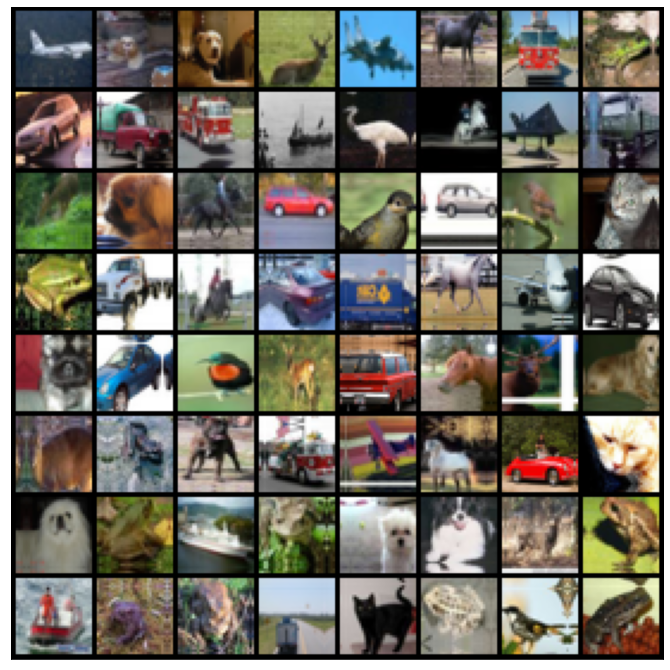

In [7]:

show_batch(train_dl)

# 3. Using device

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# 4. Resnet9
<img src = 'net.svg'>

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, train_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc'], result['train_acc']))

In [26]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [27]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# 5. Trainning model:
- Learning rate decay with ["One Cycle Learning Rate Policy"](https://sgugger.github.io/the-1cycle-policy.html)
- Weight decay (regularization)
- Gradient cliping

In [28]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_acces = []
        lrs = []
        for batch in train_loader:
            loss, acc = model.training_step(batch)
            train_losses.append(loss)
            train_acces.append(acc)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acces).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.09931640326976776, 'val_loss': 2.308053731918335}]

In [30]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [31]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00394, train_loss: 1.4641, val_loss: 1.6345, val_acc: 0.4599, train_acc: 0.4879
Epoch [1], last_lr: 0.00935, train_loss: 1.0734, val_loss: 1.8775, val_acc: 0.5138, train_acc: 0.6336
Epoch [2], last_lr: 0.00972, train_loss: 0.8145, val_loss: 0.7578, val_acc: 0.7421, train_acc: 0.7225
Epoch [3], last_lr: 0.00812, train_loss: 0.6252, val_loss: 0.7100, val_acc: 0.7750, train_acc: 0.7873
Epoch [4], last_lr: 0.00556, train_loss: 0.5098, val_loss: 0.5065, val_acc: 0.8280, train_acc: 0.8261
Epoch [5], last_lr: 0.00283, train_loss: 0.4037, val_loss: 0.4442, val_acc: 0.8539, train_acc: 0.8626
Epoch [6], last_lr: 0.00077, train_loss: 0.2977, val_loss: 0.3025, val_acc: 0.8974, train_acc: 0.8977
Epoch [7], last_lr: 0.00000, train_loss: 0.2116, val_loss: 0.2753, val_acc: 0.9079, train_acc: 0.9271
CPU times: user 7min 33s, sys: 7.35 s, total: 7min 40s
Wall time: 9min 9s


In [36]:
def plot_accuracies(history):
    val_acces = [x['val_acc'] for x in history]
    train_acces = [x.get('train_acc') for x in history]
    plt.plot(train_acces, '-bx')
    plt.plot(val_acces, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

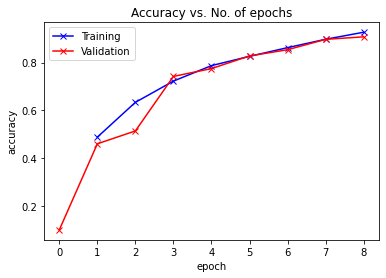

In [37]:
plot_accuracies(history)

In [34]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

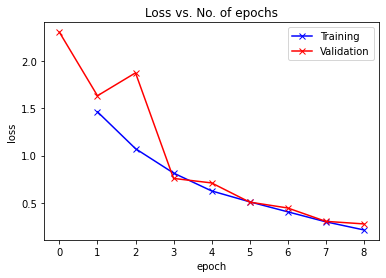

In [35]:
plot_losses(history)

In [38]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

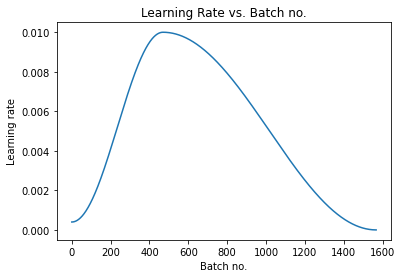

In [39]:
plot_lrs(history)

# 5. Testing with individual images

In [40]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


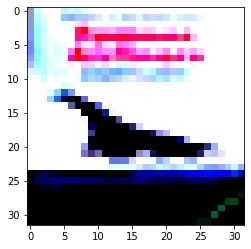

In [41]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

# 6. Analyst error

In [59]:
preds_all = []
actual_all = []
for batch in valid_dl:
  model.eval()
  images, labels = batch 
  outs = model(images)
  _, preds = torch.max(outs, dim=1)
  preds_all += preds.cpu().numpy().tolist()
  actual_all += labels.cpu().numpy().tolist()
  # print(labels)
  # print(preds)
  # break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [63]:
confusion_matrix(actual_all, preds_all)

array([[930,   4,  19,   8,   4,   1,   1,   0,  23,  10],
       [  5, 967,   0,   1,   0,   0,   0,   0,   4,  23],
       [ 27,   0, 851,  29,  31,  18,  28,   8,   5,   3],
       [ 13,   1,  24, 806,  27,  79,  23,  15,   4,   8],
       [  6,   1,  24,  20, 912,  15,  11,  11,   0,   0],
       [  4,   0,  13,  90,  21, 846,   6,  20,   0,   0],
       [  6,   0,  15,  23,   9,   3, 940,   2,   1,   1],
       [  8,   0,   9,  15,  17,  17,   2, 927,   2,   3],
       [ 33,   9,   4,   2,   0,   1,   1,   1, 941,   8],
       [ 12,  29,   0,   4,   0,   0,   0,   0,   8, 947]])

In [78]:
confu = confusion_matrix(actual_all, preds_all)
acc_label = [confu[i,i]/ sum(confu[i]) for i in range(len(confu))]
dict(zip(acc_label, train_ds.classes))

{0.806: 'cat',
 0.846: 'dog',
 0.851: 'bird',
 0.912: 'deer',
 0.927: 'horse',
 0.93: 'airplane',
 0.94: 'frog',
 0.941: 'ship',
 0.947: 'truck',
 0.967: 'automobile'}

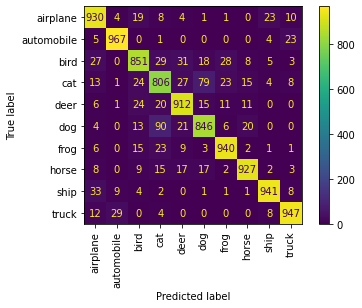

In [74]:
ConfusionMatrixDisplay.from_predictions(actual_all, preds_all, 
                                        display_labels = train_ds.classes,
                                        xticks_rotation = 'vertical',
                                        # normalize = 'true',
                                        # values_format = '.2f'
                                        )

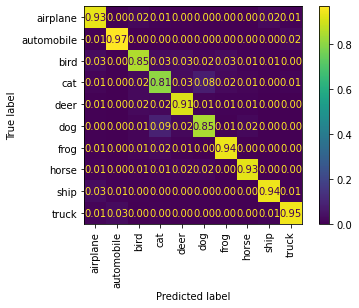

In [72]:
ConfusionMatrixDisplay.from_predictions(actual_all, preds_all, 
                                        display_labels = train_ds.classes,
                                        xticks_rotation = 'vertical',
                                        normalize = 'true',
                                        values_format = '.2f')

In [85]:
wrong_index = [i for i in range(len(actual_all)) if actual_all[i] != preds_all[i] ]
len(wrong_index )

933

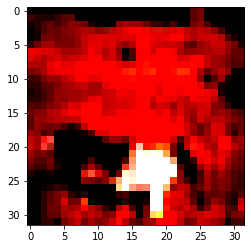

Label: deer , Predicted: cat


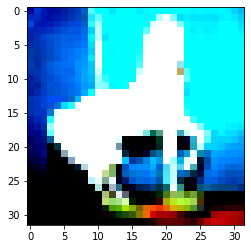

Label: horse , Predicted: airplane


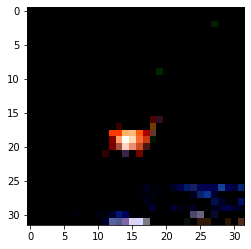

Label: deer , Predicted: bird


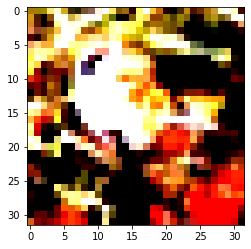

Label: bird , Predicted: cat


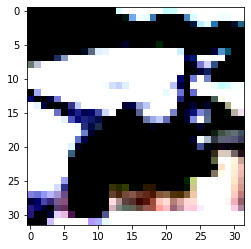

Label: horse , Predicted: airplane


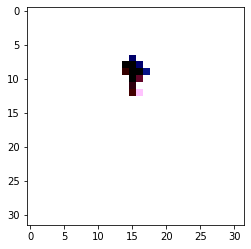

Label: airplane , Predicted: bird


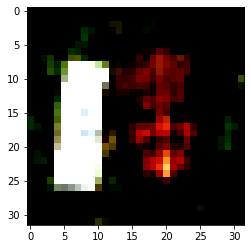

Label: frog , Predicted: bird


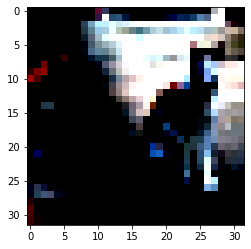

Label: cat , Predicted: horse


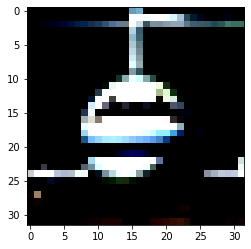

Label: airplane , Predicted: ship


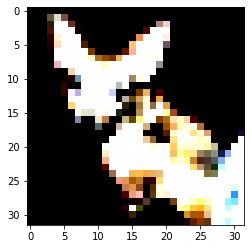

Label: dog , Predicted: cat


In [88]:
# display 10 random images predict error
for i in np.random.choice(wrong_index, 10, replace=False):
  img, label = valid_ds[i]
  plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
  plt.show()
  print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

# 7. Save and load model

In [89]:
torch.save(model.state_dict(), 'cifar10-resnet.pth')

In [90]:
model2 = to_device(ResNet9(3, 10), device)

In [91]:
model2.load_state_dict(torch.load('cifar10-resnet.pth'))

<All keys matched successfully>

In [92]:
evaluate(model, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.9078527688980103, 'val_loss': 0.27533623576164246}

In [93]:
evaluate(model2, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.9078527688980103, 'val_loss': 0.27533623576164246}